In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

In [3]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Cell 2: Load and prepare the data
# Create DataFrame
df = pd.read_csv(os.path.join('backend', 'data', 'tqbr', 'SBER.csv'))

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Display basic information
print("Data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nBasic statistics:")
print(df.describe())

Data shape: (3153, 5)

First 5 rows:
             Open    High    Low  Close   Volume
Date                                            
2013-03-25  96.00  101.14  96.00  98.79   593680
2013-03-26  98.58   99.31  97.08  97.20  1283550
2013-03-27  97.90   98.00  95.39  96.75  1261950
2013-03-28  96.38   98.66  95.72  98.59  1971410
2013-03-29  98.60   99.09  98.32  98.76   782000

Data types:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

Basic statistics:
              Open         High          Low        Close        Volume
count  3153.000000  3153.000000  3153.000000  3153.000000  3.153000e+03
mean    193.393356   195.584516   190.994244   193.375363  6.904795e+07
std      81.515914    82.116946    80.768662    81.475245  5.826816e+07
min      53.040000    55.450000    47.210000    53.500000  5.936800e+05
25%     117.120000   119.550000   114.370000   118.200000  3.553228e+07
50%     201.000000   204.330000   197.580000   201.2

In [8]:
# Cell 3: Transform prices to returns
# Calculate returns for Close, High, and Low
df['Close_Return'] = df['Close'].pct_change() * 100
df['High_Return'] = ((df['High'] / df['Close'].shift(1)) - 1) * 100
df['Low_Return'] = ((df['Low'] / df['Close'].shift(1)) - 1) * 100
# Drop the first row with NaN values
df = df.dropna()

In [9]:
# Cell 4: Create features
# Create lagged features (1-5 days)
for lag in range(1, 6):
    df[f'Close_Return_lag_{lag}'] = df['Close_Return'].shift(lag)
    df[f'High_Return_lag_{lag}'] = df['High_Return'].shift(lag)
    df[f'Low_Return_lag_{lag}'] = df['Low_Return'].shift(lag)

# Create moving averages (excluding current price)
df['Close_Return_MA_5'] = df['Close_Return'].shift(1).rolling(window=5).mean()
df['Close_Return_MA_10'] = df['Close_Return'].shift(1).rolling(window=10).mean()

# Create more sophisticated rolling statistics
# Standard deviation
df['Close_Return_Std_5'] = df['Close_Return'].shift(1).rolling(window=5).std()

# Polynomial fit coefficients (quadratic fit to last 5 days)
def get_poly_coefficients(window):
    if len(window) < 5:
        return [np.nan, np.nan, np.nan]
    x = np.arange(5)
    y = window.values
    # Fit quadratic polynomial: ax^2 + bx + c
    coeffs = np.polyfit(x, y, 2)
    return coeffs

# Apply polynomial fit to rolling windows
poly_coeffs = df['Close_Return'].shift(1).rolling(window=5).apply(
    lambda w: get_poly_coefficients(w)[0], raw=False
)
df['Close_Return_Poly_a'] = poly_coeffs

poly_coeffs = df['Close_Return'].shift(1).rolling(window=5).apply(
    lambda w: get_poly_coefficients(w)[1], raw=False
)
df['Close_Return_Poly_b'] = poly_coeffs

# Trend strength (R-squared of the polynomial fit)
def get_r_squared(window):
    if len(window) < 5:
        return np.nan
    x = np.arange(5)
    y = window.values
    # Fit quadratic polynomial
    coeffs = np.polyfit(x, y, 2)
    p = np.poly1d(coeffs)
    # Calculate R-squared
    yhat = p(x)
    ybar = np.sum(y) / len(y)
    ssreg = np.sum((yhat - ybar)**2)
    sstot = np.sum((y - ybar)**2)
    return ssreg / sstot if sstot > 0 else 0

df['Close_Return_Trend_Strength'] = df['Close_Return'].shift(1).rolling(window=5).apply(
    lambda w: get_r_squared(w), raw=False
)

# Drop rows with NaN values
df = df.dropna()

In [10]:
# Cell 5: Prepare data for modeling
# Define features
lag_features = []
for lag in range(1, 6):
    lag_features.extend([
        f'Close_Return_lag_{lag}', 
        f'High_Return_lag_{lag}', 
        f'Low_Return_lag_{lag}'
    ])

rolling_features = [
    'Close_Return_MA_5', 'Close_Return_MA_10', 
    'Close_Return_Std_5',
    'Close_Return_Poly_a', 'Close_Return_Poly_b',
    'Close_Return_Trend_Strength'
]

features = lag_features + rolling_features

# Define target (next day's close return)
target = 'Close_Return'

# Split data (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Cell 6: Train models
# Train RidgeCV
ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0])
ridge_cv.fit(X_train_scaled, y_train)

# Train ExtraTreesRegressor
et_regressor = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_regressor.fit(X_train, y_train)

ExtraTreesRegressor(random_state=42)

In [12]:
# Cell 7: Make predictions and evaluate
# Make predictions
ridge_pred = ridge_cv.predict(X_test_scaled)
et_pred = et_regressor.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"{model_name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R2: {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

ridge_metrics = evaluate_model(y_test, ridge_pred, "RidgeCV")
et_metrics = evaluate_model(y_test, et_pred, "ExtraTreesRegressor")

RidgeCV Performance:
  RMSE: 1.4799
  MAE: 1.0139
  R2: -0.0209
ExtraTreesRegressor Performance:
  RMSE: 1.5217
  MAE: 1.0488
  R2: -0.0795


In [13]:
# Cell 8: Convert return predictions to price predictions
# Get the last known close price
last_close_price = df['Close'].iloc[train_size-1]

# Function to convert returns to prices
def returns_to_prices(last_price, returns):
    prices = [last_price]
    for ret in returns:
        prices.append(prices[-1] * (1 + ret/100))
    return prices[1:]  # Exclude the initial price

# Convert predictions to prices
ridge_price_pred = returns_to_prices(last_close_price, ridge_pred)
et_price_pred = returns_to_prices(last_close_price, et_pred)

# Get actual prices
actual_prices = test_data['Close'].values

# Evaluate price predictions
ridge_price_metrics = evaluate_model(actual_prices, ridge_price_pred, "RidgeCV (Price)")
et_price_metrics = evaluate_model(actual_prices, et_price_pred, "ExtraTreesRegressor (Price)")

RidgeCV (Price) Performance:
  RMSE: 100.8123
  MAE: 75.6562
  R2: -12.5120
ExtraTreesRegressor (Price) Performance:
  RMSE: 80.7279
  MAE: 60.6588
  R2: -7.6644


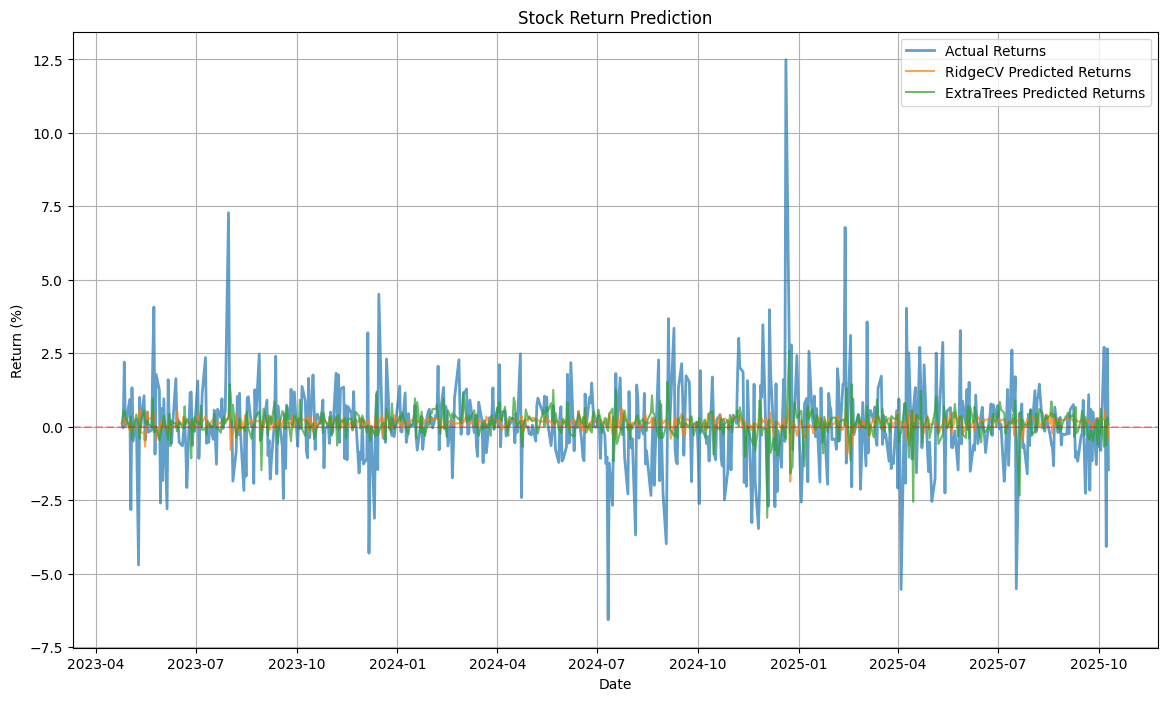

In [15]:
# Cell 8a: Visualize return predictions
plt.figure(figsize=(14, 8))
plt.plot(test_data.index, y_test, label='Actual Returns', linewidth=2, alpha=0.7)
plt.plot(test_data.index, ridge_pred, label='RidgeCV Predicted Returns', alpha=0.7)
plt.plot(test_data.index, et_pred, label='ExtraTrees Predicted Returns', alpha=0.7)
plt.title('Stock Return Prediction')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.legend()
plt.grid(True)
plt.show()

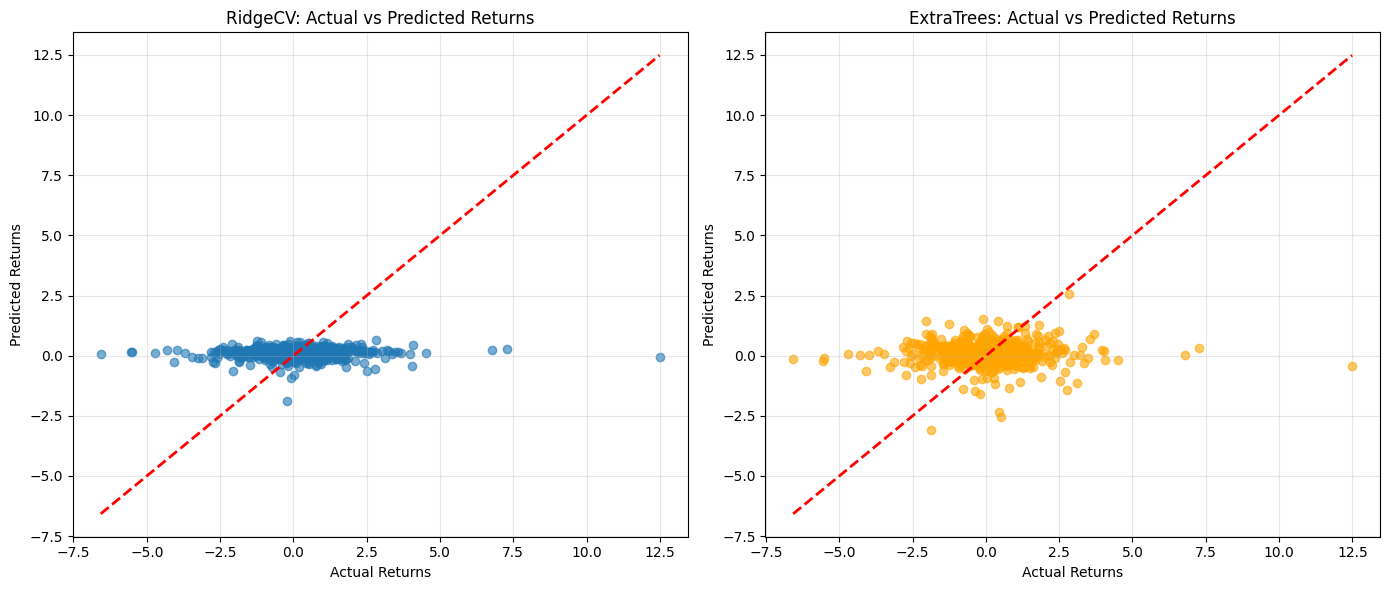

In [16]:
# Cell 8b: Scatter plot of actual vs predicted returns
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, ridge_pred, alpha=0.6, label='RidgeCV')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('RidgeCV: Actual vs Predicted Returns')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, et_pred, alpha=0.6, label='ExtraTrees', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('ExtraTrees: Actual vs Predicted Returns')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

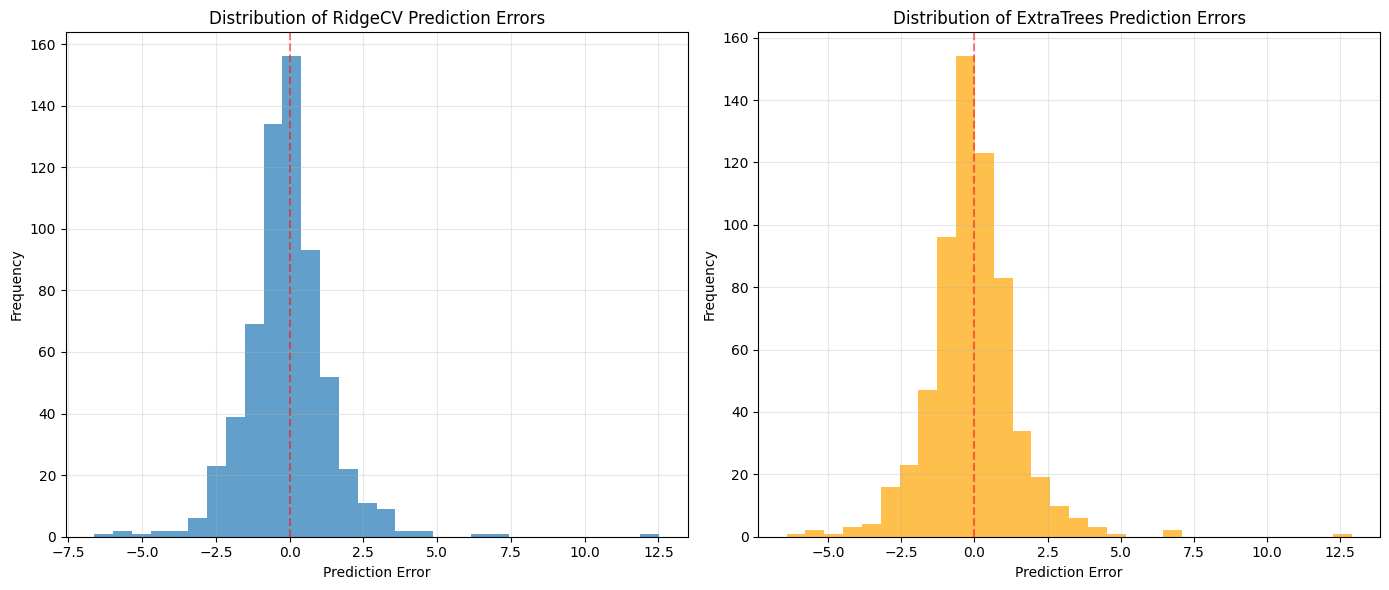

In [17]:
# Cell 8c: Distribution of prediction errors
ridge_errors = y_test - ridge_pred
et_errors = y_test - et_pred

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(ridge_errors, bins=30, alpha=0.7, label='RidgeCV')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of RidgeCV Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(et_errors, bins=30, alpha=0.7, label='ExtraTrees', color='orange')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of ExtraTrees Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

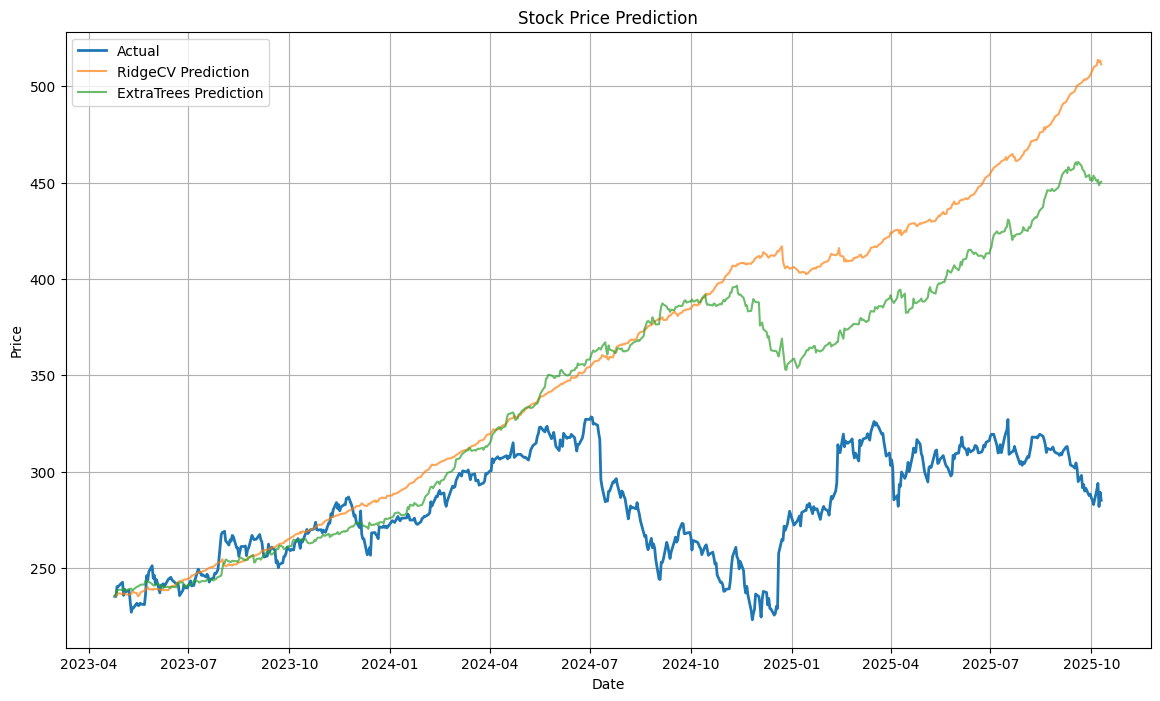

In [14]:
# Cell 9: Visualize results
plt.figure(figsize=(14, 8))
plt.plot(test_data.index, actual_prices, label='Actual', linewidth=2)
plt.plot(test_data.index, ridge_price_pred, label='RidgeCV Prediction', alpha=0.7)
plt.plot(test_data.index, et_price_pred, label='ExtraTrees Prediction', alpha=0.7)
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Cell 10: Save models
# Save the trained models and scaler
joblib.dump(ridge_cv, 'ridge_cv_model.joblib')
joblib.dump(et_regressor, 'et_regressor_model.joblib')
joblib.dump(scaler, 'feature_scaler.joblib')

print("Models saved successfully!")

Models saved successfully!
